In [39]:
import stats
import split_scale
import aquire
import features
from env import host, user, password
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer, PowerTransformer
from sklearn.linear_model import LinearRegression, LassoCV
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing
import matplotlib
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from pydataset import data
from statsmodels.formula.api import ols
import re
import multiprocessing as mp

## -Aquire

In [21]:
def get_df():
    url = f'mysql+pymysql://{user}:{password}@{host}/zillow'
    df = pd.read_sql('''select bathroomcnt, bedroomcnt, fireplacecnt, yearbuilt, taxvaluedollarcnt,calculatedfinishedsquarefeet from properties_2017 join propertylandusetype using (propertylandusetypeid) join predictions_2017 using (parcelid) where transactiondate between "2017-05-01" and "2017-06-30" and propertylandusedesc = "Single Family Residential";''', url)
    return df

## -Prepare 

In [14]:
def prepare_df():
    df = get_df()
    df = df.dropna()
    df.columns = ("bathroom_count", "bedroom_count", "fireplace_count", "year_built", "home_value", "square_feet")
    info = df.info()
    head = df.head()
    df[np.abs(df - df.mean()) <= (3*df.std())]
    return df, info, head


import split_scale_1
import feature_selection
import evaluation
import model_2

## - Split & Scale

In [35]:
def split_my_data(df, train_size):
    from sklearn.model_selection import train_test_split
    train, test = train_test_split(df, train_size = train_size, random_state = 123)
    return train, test


def standard_scaler(train, test):
    scaler=StandardScaler(copy=True,with_mean=True,with_std=True).fit(train)
    train_scaled_data=scaler.transform(train)
    test_scaled_data=scaler.transform(test)
    train_scaled=pd.DataFrame(train_scaled_data,columns=train.columns).set_index([train.index])
    test_scaled=pd.DataFrame(test_scaled_data,columns=test.columns).set_index([test.index])
    return scaler, train_scaled, test_scaled

def split_data(df):
    train, test = split_my_data(df, .70)
    scaler, train_scaled, test_scaled = standard_scaler(train, test)
    X_train = train.drop(columns = ["home_value"])
    X_test = test.drop(columns = ["home_value"])
    y_train = train[["home_value"]]
    y_test = test[["home_value"]]
    X_train_scaled = train_scaled.drop(columns = ["home_value"])
    X_test_scaled = test_scaled.drop(columns = ["home_value"])
    y_train_scaled = train_scaled[["home_value"]]
    y_test_scaled = test_scaled[["home_value"]]
    return train, test, X_train, X_test, y_train, y_test, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled

## - Exploration

In [57]:
df, info, head = prepare_df()
train, test, X_train, X_test, y_train, y_test, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled = split_data(df)
#Null: no corr exists between bathroom_count and bedroom_count
#alt: corr exists between bathroom_count and bedroom_count
means = df.bathroom_count.mean()
xbar = df.bedroom_count.mean()
s = df.bedroom_count.std()
n = df.bedroom_count.shape[0]
degf = n - 1
standard_error = s / sqrt(n)
t = (xbar - means)/(s / sqrt(n))
p = stats.t(degf).sf(t) * 2
p,t

#show corr between variables
def corr_chart():
    corr = df.corr()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr, cmap="bone_r", vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0, len(df.columns),1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=90)
    ax.set_yticks(ticks)
    ax.set_xticklabels(df.columns)
    ax.set_yticklabels(df.columns)
    return plt.show
#these are for later use
def plot_regression(x,y):
    res = sm.OLS(y, x).fit()
    prstd, iv_l, iv_u = wls_prediction_std(res)

    fig, ax = plt.subplots(figsize=(8,6))

    ax.plot(x, y, 'o', label="data")
    #ax.plot(x, y, 'b-', label="True")
    ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
    ax.plot(x, iv_u, 'g--',label='97.5% Confidence Level')
    ax.plot(x, iv_l, 'b--',label='2.5% Confidence Level')
    ax.legend(loc='best');
    plt.show()
    
    
    
def plot_residuals(x, y):
    return sns.residplot(x, y)


#one of the strongest corr is bettwen bathroom_count and square_feet
#all variables appear to be correlated to the dependent, though fireplace_count, bathroom_count and bedroom_count are the 3 highest (when compaired independently)
#bathroom_count and home_value have a corr of .53, bathroom_count and square_feet have a corr of .85, and bedroom_count and square_feet share at .54 the 3 top highest corr's. 
#summary - bathroom_count, bedroom_count, and fireplace_count should be best predictors of home_value, though more research would be required to support this hypothesis. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2114 entries, 32 to 15030
Data columns (total 6 columns):
bathroom_count     2114 non-null float64
bedroom_count      2114 non-null float64
fireplace_count    2114 non-null float64
year_built         2114 non-null float64
home_value         2114 non-null float64
square_feet        2114 non-null float64
dtypes: float64(6)
memory usage: 115.6 KB


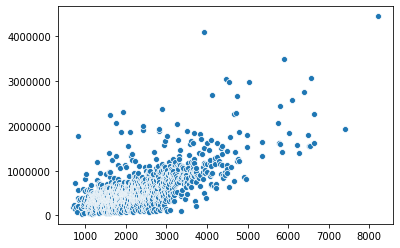

In [80]:
sns.scatterplot(data = df.groupby('square_feet').mean().home_value)

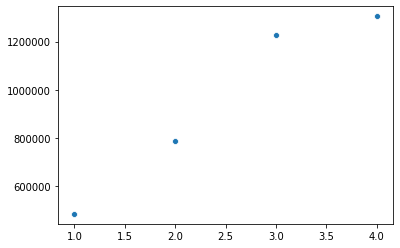

In [81]:
sns.scatterplot(data = df.groupby('fireplace_count').mean().home_value)

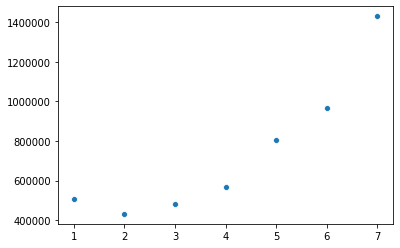

In [83]:
sns.scatterplot(data = df.groupby('bedroom_count').mean().home_value)

## -Feature Selection 

In [37]:
def optimal_number_of_features(X_train, y_train, X_test, y_test):
    number_of_attributes = X_train.shape[1]
    number_of_features_list=np.arange(1,number_of_attributes)
    high_score=0
    number_of_features=0           
    score_list =[]
    for n in range(len(number_of_features_list)):
        model = LinearRegression()
        rfe = RFE(model,number_of_features_list[n])
        X_train_rfe = rfe.fit_transform(X_train,y_train)
        X_test_rfe = rfe.transform(X_test)
        model.fit(X_train_rfe,y_train)
        score = model.score(X_test_rfe,y_test)
        score_list.append(score)
        if(score>high_score):
            high_score = score
            number_of_features = number_of_features_list[n]
    return number_of_features, high_score

def optimal_features(X_train, y_train, number_of_features):
    cols = list(X_train.columns)
    model = LinearRegression()
    rfe = RFE(model, number_of_features)
    X_rfe = rfe.fit_transform(X_train,y_train)  
    model.fit(X_rfe,y_train)
    temp = pd.Series(rfe.support_,index = cols)
    selected_features_rfe = temp[temp==True].index
    return selected_features_rfe

def optimal_dataframe(X_train, X_test, selected_features_rfe):
    X_train_df = X_train[selected_features_rfe]
    X_test_df = X_test[selected_features_rfe]
    return X_train_df, X_test_df



def select_features():
    n_features, high_score = optimal_number_of_features(X_train,y_train,X_test,y_test)
    selected_features = optimal_features(X_train,y_train,n_features)
    X_train_sf, X_test_sf = optimal_dataframe(X_train, X_test, selected_features)
    return X_train_sf, X_test_sf

## -Modeling and Evaluation

In [75]:
df, info, head = prepare_df()
train, test, X_train, X_test, y_train, y_test, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled = split_data(df)
lm = LinearRegression().fit(X_train, y_train)
lm.intercept_
lm.coef_
y_pred_baseline = np.array([y_test.mean()])
y_pred_baseline = np.repeat(y_pred_baseline, len(y_test))
pd.Series(y_pred_baseline)
y_unscaled=y_test
y_lm=y_pred_lm
y_baseline = y_pred_baseline
pd.set_option('display.float_format', lambda x: '%.3f' % x)
predict=pd.DataFrame({"actual":y_train.home_value}).reset_index(drop=True)
y_pred_lm=lm.predict(X_test)
len(y_pred_lm)
predict["baseline"] = y_train.mean()[0]
y_baseline = predict[["baseline"]]
MSE_baseline = mean_squared_error(predict.actual, predict.baseline)
SSE_baseline = MSE_baseline*len(predict.actual)
RMSE_baseline = sqrt(MSE_baseline)
r2_baseline = r2_score(predict.actual, predict.baseline)
print(MSE_baseline,SSE_baseline,RMSE_baseline,r2_baseline)
y_pred_raveled=y_pred_lm.ravel().reshape(635)
y_pred_raveled = [int(x) for x in y_pred_raveled]
y_test=np.array(y_test).ravel().reshape(635)
pd.DataFrame({'predicted_values':y_pred_raveled,'real_values':y_test})
x = df[["bathroom_count", "bedroom_count", "square_feet"]]
y= df['home_value']
df_regress = pd.DataFrame({})
df_regress["y"] = y
ols_model = ols('y ~ x', data=df_regress).fit()
df_regress['yhat'] = ols_model.predict(x)
df_regress['residual'] = df_regress['yhat'] - df_regress['y']
df_regress.head()
df_regress['residual^2'] = df_regress.residual ** 2
SSE_2 = mean_squared_error(df_regress.y, df_regress.yhat)*len(df_regress)
MSE_2 = mean_squared_error(df_regress.y, df_regress.yhat)
RMSE_2 = sqrt(MSE_2)
df_regress = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
df_regress['model_error'] = np.array([SSE_2, MSE_2, RMSE_2])
df_regress['baseline_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])
df_regress['error_delta'] = df_regress.model_error - df_regress.baseline_error
evs = explained_variance_score(y_test, y_pred_baseline)
df_regress, evs
accuracy_score = lm.score(X_test, y_test)
pd.Series(y_pred_baseline)
y_unscaled=y_test
y_lm=y_pred_lm
y_baseline = y_pred_baseline
pd.set_option('display.float_format', lambda x: '%.3f' % x)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2114 entries, 32 to 15030
Data columns (total 6 columns):
bathroom_count     2114 non-null float64
bedroom_count      2114 non-null float64
fireplace_count    2114 non-null float64
year_built         2114 non-null float64
home_value         2114 non-null float64
square_feet        2114 non-null float64
dtypes: float64(6)
memory usage: 115.6 KB
180362963639.6578 266756823223053.9 424691.6100415192 0.0


In [72]:
df.corr()

,bathroom_count,bedroom_count,fireplace_count,year_built,home_value,square_feet
bathroom_count,1.000,0.519,0.439,0.505,0.525,0.825
bedroom_count,0.519,1.000,0.199,0.224,0.240,0.543
fireplace_count,0.439,0.199,1.000,0.277,0.390,0.575
year_built,0.505,0.224,0.277,1.000,0.317,0.492
home_value,0.525,0.240,0.390,0.317,1.000,0.611
square_feet,0.825,0.543,0.575,0.492,0.611,1.000


<function matplotlib.pyplot.show(*args, **kw)>

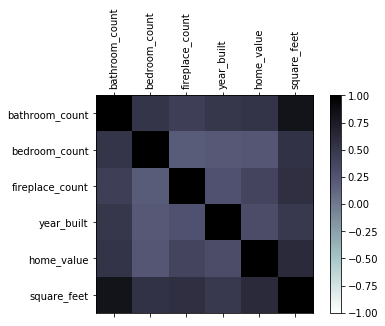

In [74]:
corr_chart()

In [92]:
df_origin_final = pd.DataFrame({'actual': y_unscaled,
             'lm': y_lm.ravel(),
             'lm_baseline':y_baseline.ravel()})
df_origin_final.head()

(      actual          lm  lm_baseline
 0 214514.000  297307.841   557226.616
 1 680345.000  352429.435   557226.616
 2 288645.000  483292.516   557226.616
 3  74465.000  548623.406   557226.616
 4 773269.000 1353314.796   557226.616, 0.4129589927368235)

In [102]:
print(f"r2 score for lm is:{lm.score(X_test, y_test)}")

r2 score for lm is:0.4129589927368235


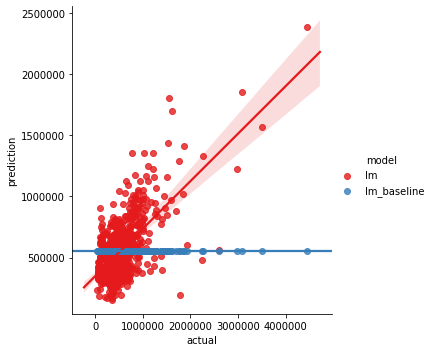

In [97]:
df_chart = pd.DataFrame({'actual': y_unscaled,'lm': y_lm.ravel(),'lm_baseline':y_baseline.ravel()}).melt(id_vars=['actual'],var_name='model',value_name='prediction').pipe((sns.lmplot,'data'),x='actual',y='prediction',hue='model',palette="Set1")

#### Above shows the corrolation tests, along with a plot of the lm model to the lm baseline. 

In [99]:
X_train_2 = train[["bedroom_count", "fireplace_count", "square_feet","bathroom_count"]]
X_test_2 = test[["bedroom_count", "fireplace_count", "square_feet", "bathroom_count"]]
lm2 = LinearRegression().fit(X_train_2, y_train)
lms2 = lm2.score(X_test_2, y_test)
lms = lm.score(X_test, y_test)
print(f"The orignial r2 score for lm{lms}, given the new train and test variables the new r2 score is{lms2}")

The orignial r2 score for lm0.4129589927368235, given the new train and test variables the new r2 score is0.41395241286384926


### - Above shows a lms2's score preforms lms1's score, and therefore is a better predictive model. 

In [106]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
predict=pd.DataFrame({"actual":y_train.home_value}).reset_index(drop=True)
y_pred_lm_2=lm2.predict(X_test_2)
y_lm_2=y_pred_lm_2
predict["baseline"] = y_train.mean()[0]
y_pred_raveled_2=y_pred_lm_2.ravel().reshape(635)
y_test=np.array(y_test).ravel().reshape(635)
pd.DataFrame({'predicted_values':y_pred_raveled_2,'real_values':y_test})
x = df[["bedroom_count", "fireplace_count", "square_feet","bathroom_count"]]
y= df['home_value']
df_regress_2 = pd.DataFrame({})
df_regress_2["y"] = y
ols_model_2 = ols('y ~ x', data=df_regress_2).fit()
df_regress_2['yhat'] = ols_model_2.predict(x)
df_regress_2['residual'] = df_regress_2['yhat'] - df_regress_2['y']
df_regress_2.head()
df_regress_2['residual^2'] = df_regress_2.residual ** 2
SSE_2 = mean_squared_error(df_regress_2.y, df_regress_2.yhat)*len(df_regress_2)
MSE_2 = mean_squared_error(df_regress_2.y, df_regress_2.yhat)
RMSE_2 = sqrt(MSE_2)
df_regress_2 = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
df_regress_2['model_error'] = np.array([SSE_2, MSE_2, RMSE_2])
df_regress_2['baseline_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])
df_regress_2['error_delta'] = df_regress_2.model_error - df_regress_2.baseline_error
evs = explained_variance_score(y_test, y_pred_baseline)
df_regress_2, df_regress

(  metric         model_error      baseline_error         error_delta
 0    SSE 231043972220226.781 266756823223053.906 -35712851002827.125
 1    MSE    109292323661.413    180362963639.658    -71070639978.245
 2   RMSE          330593.895          424691.610          -94097.715,
   metric         model_error      baseline_error         error_delta
 0    SSE 231431367284093.156 266756823223053.906 -35325455938960.750
 1    MSE    109475575820.290    180362963639.658    -70887387819.368
 2   RMSE          330870.935          424691.610          -93820.675)

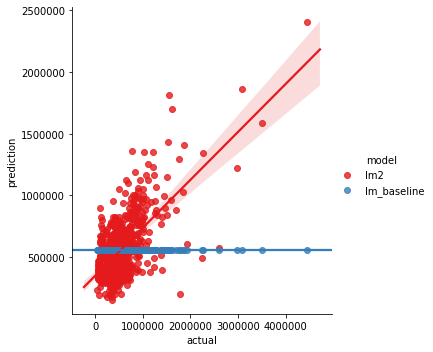

In [107]:
df_chart = pd.DataFrame({'actual': y_unscaled,'lm2': y_lm_2.ravel(),'lm_baseline':y_baseline.ravel()}).melt(id_vars=['actual'],var_name='model',value_name='prediction').pipe((sns.lmplot,'data'),x='actual',y='prediction',hue='model',palette="Set1")

### -using the new variables we've been able to lower our error delta by 277.03 points, meaning we've increased the accuracy by about 1%

1.0029528672651309